In [1]:
!pip install numba==0.55.2 

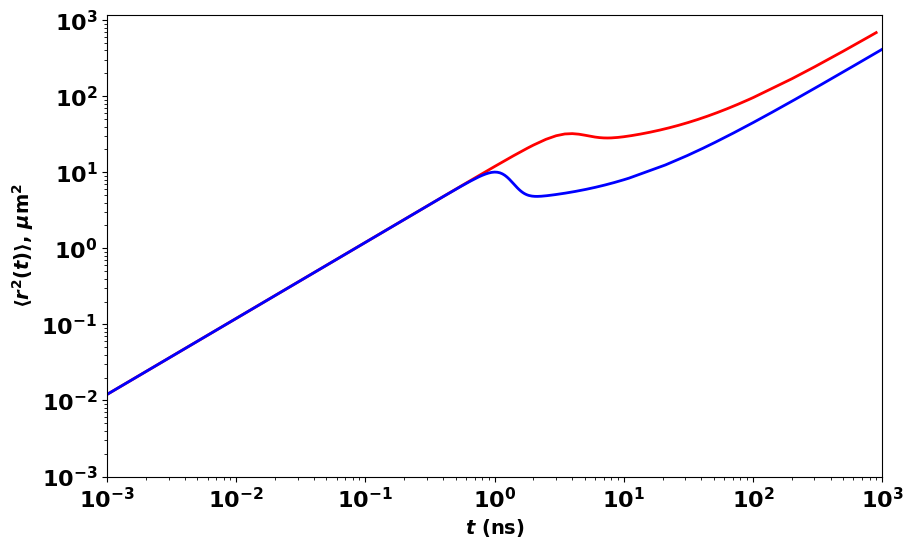

In [4]:
from utils import import_analytical_msd_df, plot_analytical_msd_single

msd_7_csv_path = r'data/msd_Fig7'
msd_8_csv_path = r'data/msd_Fig8_1000'
#msd_9_csv_path = r'data/msd_Fig9'

msd_7_df = import_analytical_msd_df(msd_7_csv_path)
msd_8_df = import_analytical_msd_df(msd_8_csv_path)
#msd_9_df = import_analytical_msd_df(msd_9_csv_path)

plot_analytical_msd_single(msd_7_df, msd_8_df) # msd_7_df, msd_8_df, msd_9_df

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from numba import jit, njit
import tqdm
from multiprocessing import Pool


plt.rcParams.update({'font.size': 16,
                     'font.weight': 'bold'
                     })

from simulation import get_analytical_parameter_corresp, sim_traj

from utils import plot_msd, plot_num, import_analytical_msd_df, import_analytical_num_df, save_load_traj, plot_msd_with_analytical_bin, plot_num_with_analytical_bin

## No recombination

In [2]:
random_state = 425
n_ensemble = 1_000
t_cutoff = 1000
t_step = 0.001
alpha = 0.0
lambda_A = 1.0
lambda_B = 0.03
D_A,D_B =  3.0, 0.1
tau_A, tau_B, sim_lambda_A, sim_lambda_B, sim_alpha = get_analytical_parameter_corresp(D_A=D_A, D_B=D_B, lambda_A=lambda_A, lambda_B=lambda_B, alpha=alpha)

result = sim_traj(n_ensemble, t_cutoff, t_step, tau_A, tau_B, alpha, lambda_A, lambda_B, random_state)

100%|██████████| 999999/999999 [01:04<00:00, 15536.52it/s]


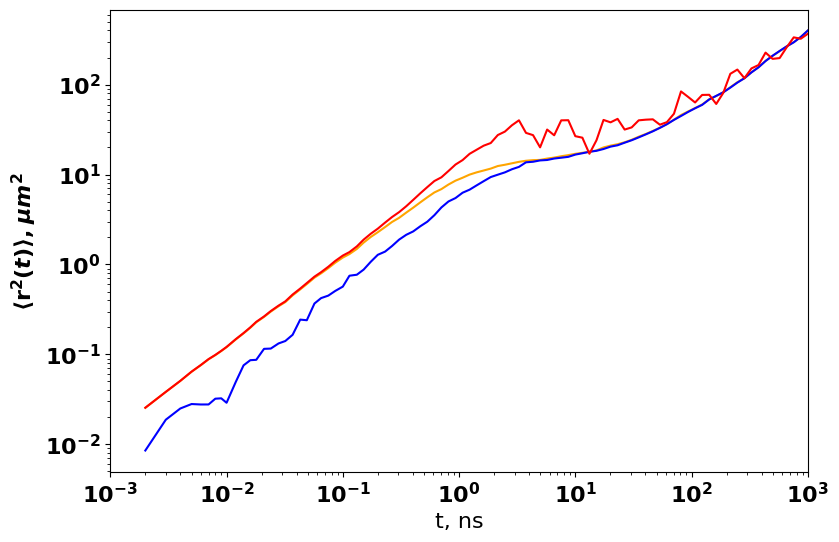

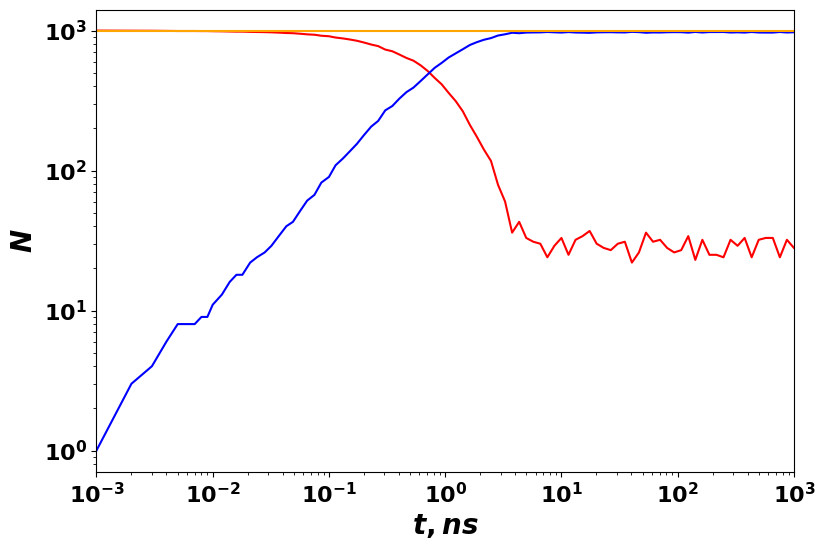

In [3]:
plot_msd(result)
plot_num(result)

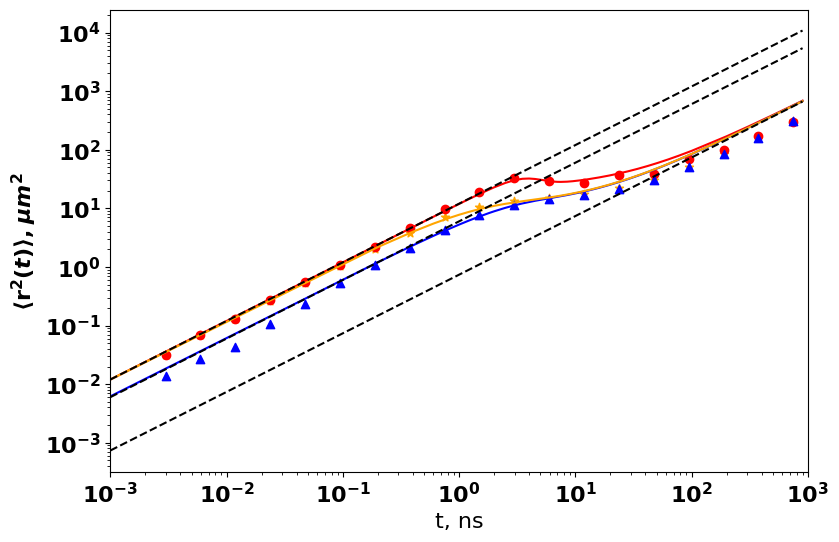

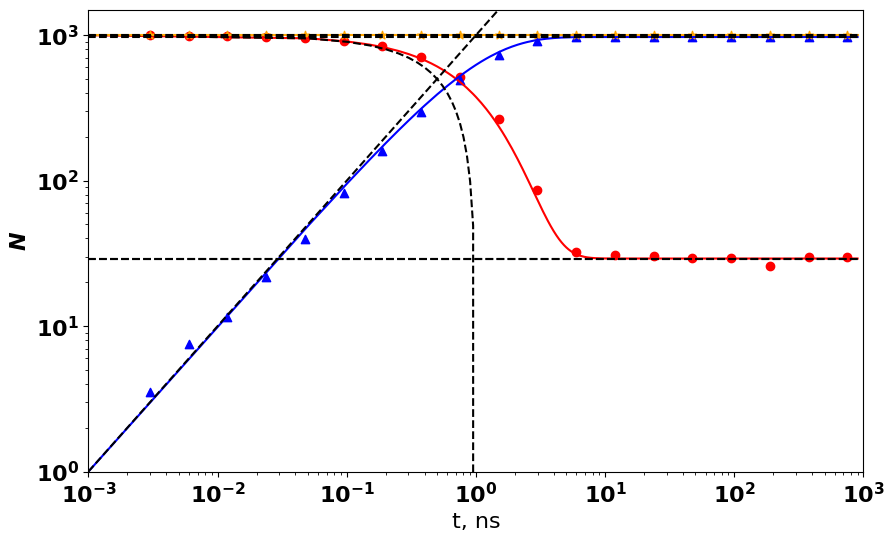

In [4]:


analytical_msd_df_path = r'data/msd_Fig7'
analytical_popul_df_path = r'data/popul_Fig7'

analytical_msd_df = import_analytical_msd_df(analytical_msd_df_path)
analytical_popul_df = import_analytical_num_df(analytical_popul_df_path)

#result = None
#result = save_load_traj(result,'sim_result_fig7_1000_opt1', load_file=True)

plot_msd_with_analytical_bin(result, analytical_msd_df, num_bins=20)
plot_num_with_analytical_bin(result, analytical_popul_df, ylim_start=1, ylim_end=1500, num_bins=20)

In [10]:
save_load_traj(result, 'sim_result_fig7_1000_opt1', load_file=False) 

True

In [50]:
from simulation import get_analytical_parameter_corresp

random_state = 425
n_ensemble = 100_000
t_cutoff = 1000
t_step = 0.001
alpha = 0.0
lambda_A = 1.0
lambda_B = 0.03
D_A,D_B =  3.0, 0.1
tau_A, tau_B, sim_lambda_A, sim_lambda_B, sim_alpha = get_analytical_parameter_corresp(D_A=D_A, D_B=D_B, lambda_A=lambda_A, lambda_B=lambda_B, alpha=alpha)

result = sim_traj(n_ensemble, t_cutoff, t_step, tau_A, tau_B, alpha, lambda_A, lambda_B, random_state)

100%|██████████| 999999/999999 [1:11:51<00:00, 231.95it/s]


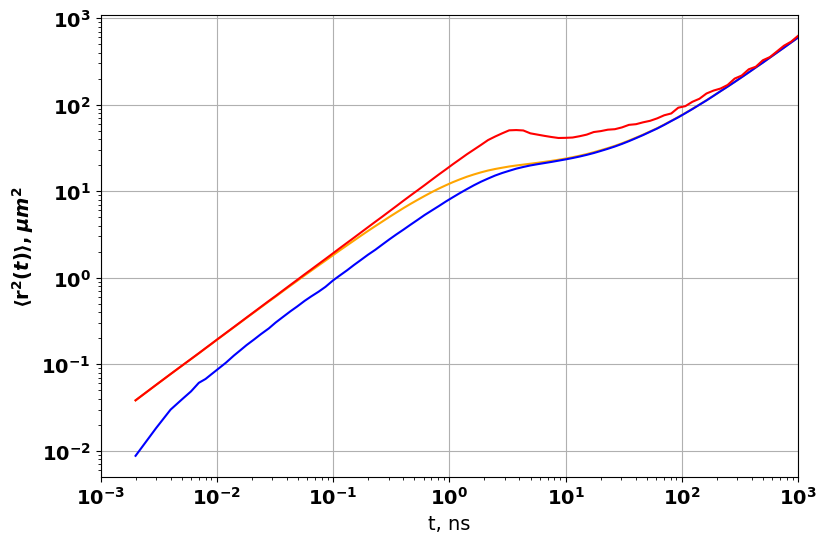

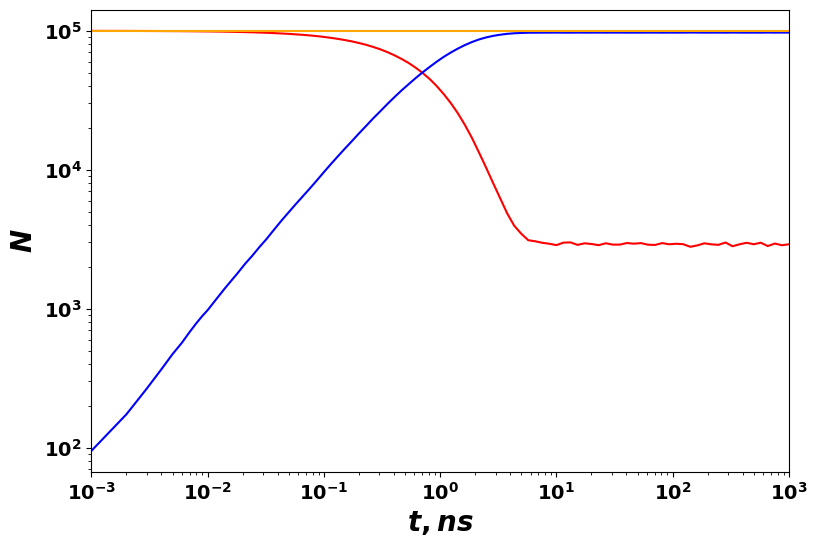

In [51]:
plot_msd(result)
plot_num(result)

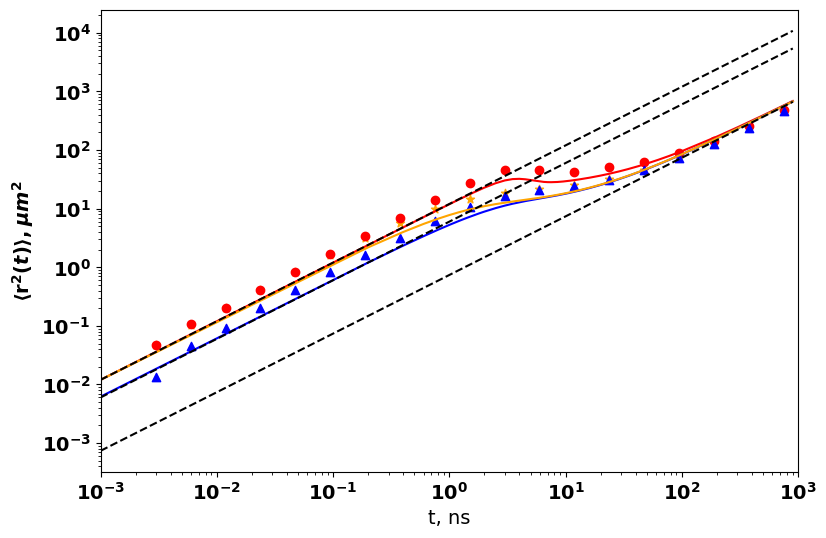

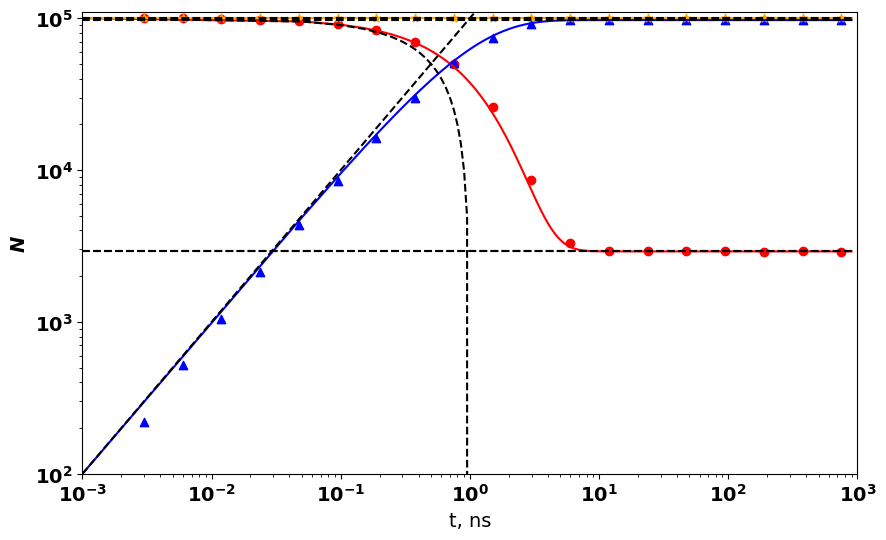

In [53]:
from utils import import_analytical_msd_df, import_analytical_num_df, save_load_traj

analytical_msd_df_path = r'data/msd_Fig7_10^5'
analytical_popul_df_path = r'data/popul_Fig7_10^5'

analytical_msd_df = import_analytical_msd_df(analytical_msd_df_path)
analytical_popul_df = import_analytical_num_df(analytical_popul_df_path)

# result = None
# result = save_load_traj(result,'sim_result_fig7_1000_opt1', load_file=True)

plot_msd_with_analytical_bin(result, analytical_msd_df, num_bins=20)
plot_num_with_analytical_bin(result, analytical_popul_df, ylim_start=100,ylim_end=110000,num_bins=20)

In [153]:
from simulation import get_analytical_parameter_corresp

random_state = 42
n_ensemble = 5*1000*1000
t_cutoff = 1000
t_step = 0.001
alpha = 5.0
lambda_A = 1.0
lambda_B = 0.03
D_A,D_B =  3.0, 0.1
tau_A, tau_B, sim_lambda_A, sim_lambda_B, sim_alpha = get_analytical_parameter_corresp(D_A=D_A, D_B=D_B, lambda_A=lambda_A, lambda_B=lambda_B, alpha=alpha)

result = sim_traj(n_ensemble, t_cutoff, t_step, tau_A, tau_B, alpha, lambda_A, lambda_B, random_state=42)

  0%|          | 46/999999 [01:28<536:29:23,  1.93s/it] 


KeyboardInterrupt: 

## Non-vectorised code

In [13]:
import pickle
import tqdm
from multiprocessing import Pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams.update({'font.size': 16,
                     'font.weight': 'bold'
                     })

from simulation import run_simulation_multi_parallel, analyze_trajectories

In [28]:
def analyze_trajectories_with_analytical_bin(trajectories, analytical_msd_df, analytical_popul_df):
    max_time_steps = trajectories[0]['t'].size
    msd_data = {'A': np.zeros(max_time_steps), 'B': np.zeros(
        max_time_steps), 'overall': np.zeros(max_time_steps)}
    population_data = {'A': np.zeros(max_time_steps), 'B': np.zeros(
        max_time_steps), 'overall': np.zeros(max_time_steps)}

    for traj in trajectories:
        initial_pos = np.array([traj['x'][0], traj['y'][0]])
        for t, (x, y, state) in enumerate(zip(traj['x'], traj['y'], traj['state'])):
            displacement = (x - initial_pos[0])**2 + (y - initial_pos[1])**2
            if state:  # Check if state is not empty
                msd_data[state][t] += displacement
                msd_data['overall'][t] += displacement
                population_data[state][t] += 1
                population_data['overall'][t] += 1

    time_steps = trajectories[0]['t']
    #plt.figure(figsize=(10, 6))
    #x = analytical_msd_df['t']
    #y_columns = ['MSD_A', 'MSD_B', 'MSD_overall']
    #y_label = ['$MSD_A$', '$MSD_B$', '$MSD_{overall}$']
    #colors = ['red', 'blue', 'orange']
    markers = ['o', '^', '*']
    #for column, label, color in zip(y_columns, y_label, colors):
    #    plt.plot(x, analytical_msd_df[column], label=label, color=color)

    x = analytical_msd_df['t']

    # Extract other columns for y-axis
    y_columns = ['MSD_A', 'MSD_B', 'MSD_overall']
    y_label = ['$MSD_A$', '$MSD_B$', '$MSD_{overall}$']
    colors = ['red', 'blue', 'orange']

    # Plot all other columns against 't'
    plt.figure(figsize=(10, 6))
    for column, label, color in zip(y_columns, y_label, colors):
        plt.plot(x, analytical_msd_df[column], label=label, color=color, linewidth=2)
    plt.plot(x, analytical_msd_df['shorttime_limit3'], linestyle='--', color='black')
    plt.plot(x, analytical_msd_df['longtime_limit'], linestyle='--', color='black')
    

    # Logarithmic binning of simulation data
    bin_edges = np.logspace(
        np.log10(min(time_steps[1:])), np.log10(max(time_steps)), 20)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    for state in ['A', 'B', 'overall']:
        msd_data[state] /= population_data[state]

    for state, color, marker in zip(['A', 'B', 'overall'], colors, markers):
        msd_data_state = msd_data[state][1:]*2 / 10_000_000_000
        valid_indices = ~np.isnan(msd_data_state)  # Find valid indices

        # Filter both arrays synchronously
        msd_data_state = msd_data_state[valid_indices]
        time_steps_filtered = time_steps[1:][valid_indices]

        bin_means, _, _ = stats.binned_statistic(
            time_steps_filtered, msd_data_state, statistic='mean', bins=bin_edges)
        plt.scatter(bin_centers, bin_means,
                    label=f'MSD: {state}', marker=marker, color=color)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(min(time_steps), max(time_steps))
    plt.xlabel('$t, ns$') # , fontweight='bold', fontsize=20
    plt.ylabel(
        '$\\langle \\mathrm{r}^2(t) \\rangle, \\mu m^2$') # , fontweight='bold', fontsize=20
    # plt.title(f"Mean Square Displacement over Time, $\\alpha$={alpha}, $\\lambda_A$={lambda_A}, $\\lambda_B$={lambda_B}, $D_A$={tau_A}, $D_B$={tau_B}")
    # plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'orange']
    x1 = analytical_popul_df['t']
    y_columns = ['num_a', 'num_b', 'num_total']
    y_label = ['$N_A$', '$N_B$', '$N_{overall}$']
    colors = ['red', 'blue', 'orange']
    markers = ['o', '^', '*']
    for column, label, color in zip(y_columns, y_label, colors):
        plt.plot(x1, analytical_popul_df[column], label=label, color=color)

    for state, color, marker in zip(['A', 'B', 'overall'], colors, markers):
        bin_means, _, _ = stats.binned_statistic(
            time_steps[1:], population_data[state][1:]/len(trajectories), statistic='mean', bins=bin_edges)
        plt.scatter(bin_centers, bin_means,
                    label=f'Population: {state}', marker=marker, color=color)
    plt.xscale('log')
    plt.yscale('log')
    # plt.ylim(0.0001,1)
    plt.xlim(min(time_steps), max(time_steps))
    plt.xlabel('$t, ns$') # , fontweight='bold', fontsize=20
    plt.ylabel('$N$') # , fontweight='bold', fontsize=20
    # plt.title(f"Population over Time, $\\alpha$={alpha}, $\\lambda_A$={lambda_A}, $\\lambda_B$={lambda_B}, $D_A$={tau_A}, $D_B$={tau_B}")
    # plt.legend()
    plt.show()


In [31]:
from simulation import get_analytical_parameter_corresp

n_ensemble = 1_000_000 #5*1000
t_cutoff = 1000
dt = 0.001
alpha = 5.0
lambda_A = 1.0
lambda_B = 0.03
D_A,D_B =  3.0, 0.1
tau_A, tau_B, sim_lambda_A, sim_lambda_B, sim_alpha = get_analytical_parameter_corresp(D_A=D_A, D_B=D_B, lambda_A=lambda_A, lambda_B=lambda_B, alpha=alpha)

result = run_simulation_multi_parallel(t_cutoff, tau_A, tau_B, dt, lambda_A, lambda_B, alpha, n_ensemble)

100%|██████████| 1000000/1000000 [2:31:08<00:00, 110.27it/s] 


[1.00000e-03 2.00000e-03 3.00000e-03 4.00000e-03 5.00000e-03 6.00000e-03
 7.00000e-03 8.00000e-03 9.00000e-03 1.00000e-02 1.10000e-02 1.30000e-02
 1.50000e-02 1.70000e-02 1.90000e-02 2.20000e-02 2.50000e-02 2.90000e-02
 3.30000e-02 3.80000e-02 4.40000e-02 5.00000e-02 5.80000e-02 6.60000e-02
 7.60000e-02 8.70000e-02 1.01000e-01 1.15000e-01 1.33000e-01 1.52000e-01
 1.75000e-01 2.01000e-01 2.32000e-01 2.66000e-01 3.06000e-01 3.52000e-01
 4.04000e-01 4.65000e-01 5.34000e-01 6.14000e-01 7.06000e-01 8.12000e-01
 9.33000e-01 1.07300e+00 1.23300e+00 1.41800e+00 1.63000e+00 1.87400e+00
 2.15500e+00 2.47800e+00 2.84900e+00 3.27500e+00 3.76500e+00 4.32900e+00
 4.97800e+00 5.72300e+00 6.58000e+00 7.56500e+00 8.69800e+00 1.00000e+01
 1.14980e+01 1.32200e+01 1.52000e+01 1.74760e+01 2.00930e+01 2.31020e+01
 2.65610e+01 3.05390e+01 3.51120e+01 4.03710e+01 4.64160e+01 5.33670e+01
 6.13600e+01 7.05490e+01 8.11140e+01 9.32610e+01 1.07227e+02 1.23285e+02
 1.41748e+02 1.62976e+02 1.87382e+02 2.15444e+02 2.

/var/folders/0z/z1b441lj31zbg8g3nwjhg74r0000gn/T/ipykernel_61217/3583799093.py:30: RuntimeWarning: invalid value encountered in true_divide
  msd_data[state] /= population_data[state]


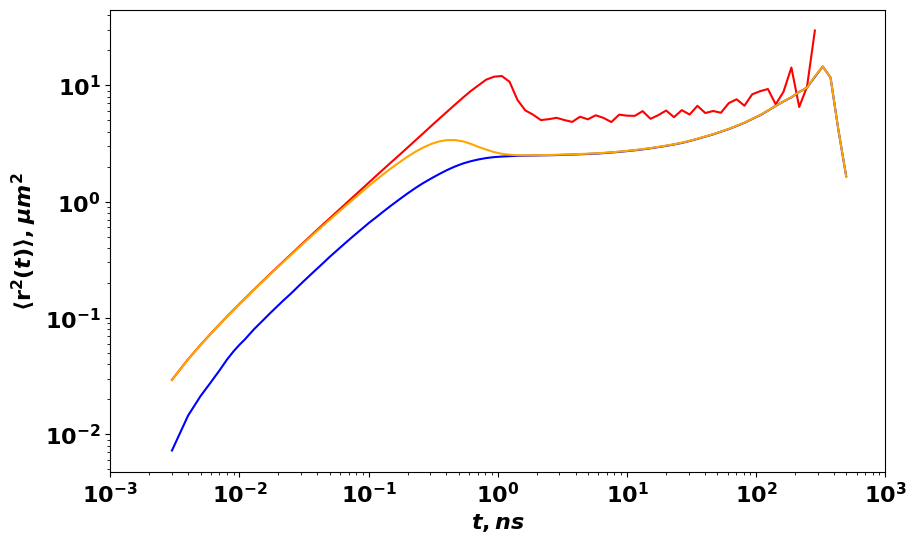

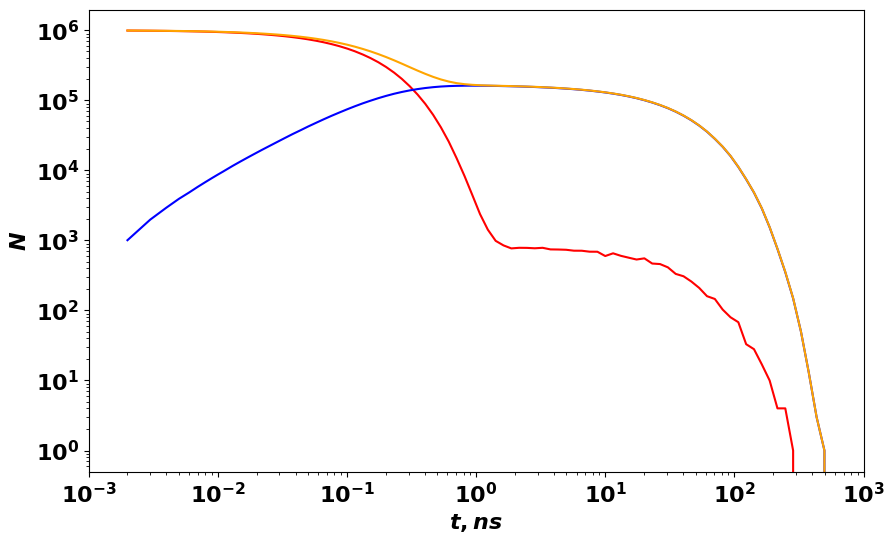

In [34]:
analyze_trajectories(result)

/var/folders/0z/z1b441lj31zbg8g3nwjhg74r0000gn/T/ipykernel_1496/868460765.py:49: RuntimeWarning: invalid value encountered in true_divide
  msd_data[state] /= population_data[state]


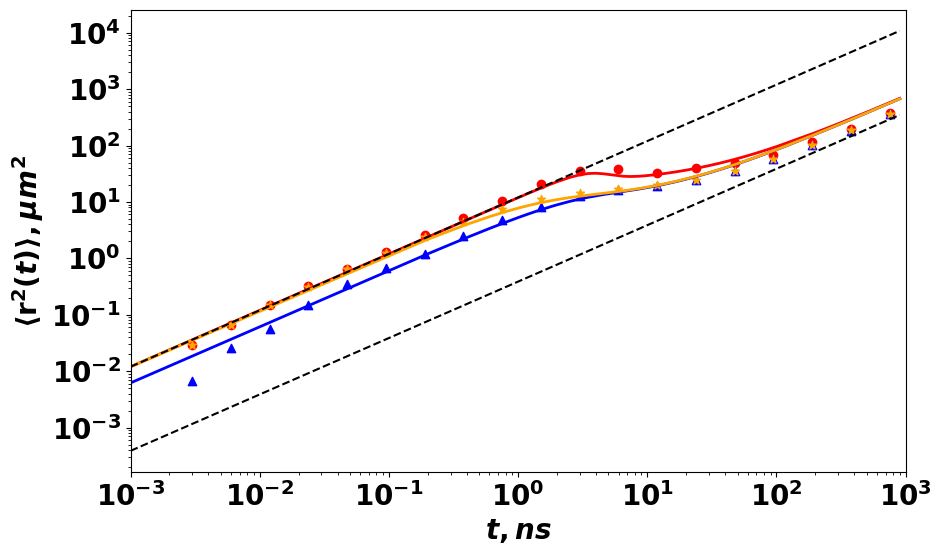

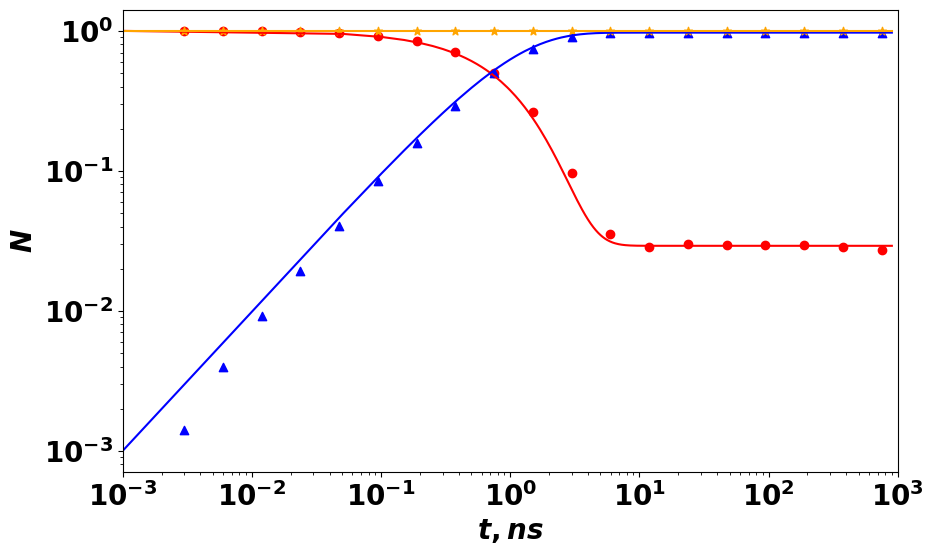

In [33]:
from utils import import_analytical_msd_df, import_analytical_num_df, save_load_traj

analytical_msd_df_path = r'/Users/a1/Downloads/model_excitons_simulation/data/msd_Fig7'
analytical_popul_df_path = r'/Users/a1/Downloads/model_excitons_simulation/data/popul_Fig7'

analytical_msd_df = import_analytical_msd_df(analytical_msd_df_path)
analytical_popul_df = import_analytical_num_df(analytical_popul_df_path)

#result = None
#result = save_load_traj(result, 'sim_msd_fig7_', load_file=True)

analyze_trajectories_with_analytical_bin(result, analytical_msd_df, analytical_popul_df)

In [49]:
from utils import save_load_traj

save_load_traj(result, 'sim_msd_fig7_', load_file=False) 
#result = None
#result = save_load_traj(result, 'sim_msd_fig8_5x10^6not0', load_file=True)

True

In [50]:
from simulation import get_analytical_parameter_corresp

n_ensemble = 5*1000*1000
t_cutoff = 1000
dt = 0.001
alpha =5.0
lambda_A = 1.0
lambda_B = 0.03
D_A,D_B =  3.0, 0.1
tau_A, tau_B, sim_lambda_A, sim_lambda_B, sim_alpha = get_analytical_parameter_corresp(D_A=D_A, D_B=D_B, lambda_A=lambda_A, lambda_B=lambda_B, alpha=alpha)

result = run_simulation_multi_parallel(t_cutoff, tau_A, tau_B, dt, lambda_A, lambda_B, alpha, n_ensemble)

 12%|█▏        | 587546/5000000 [3:28:29<18:50:27, 65.05it/s]   

/var/folders/0z/z1b441lj31zbg8g3nwjhg74r0000gn/T/ipykernel_97483/2558262614.py:29: RuntimeWarning: invalid value encountered in true_divide
  msd_data[state] /= population_data[state]
/var/folders/0z/z1b441lj31zbg8g3nwjhg74r0000gn/T/ipykernel_97483/2558262614.py:35: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(time_steps), max(time_steps))


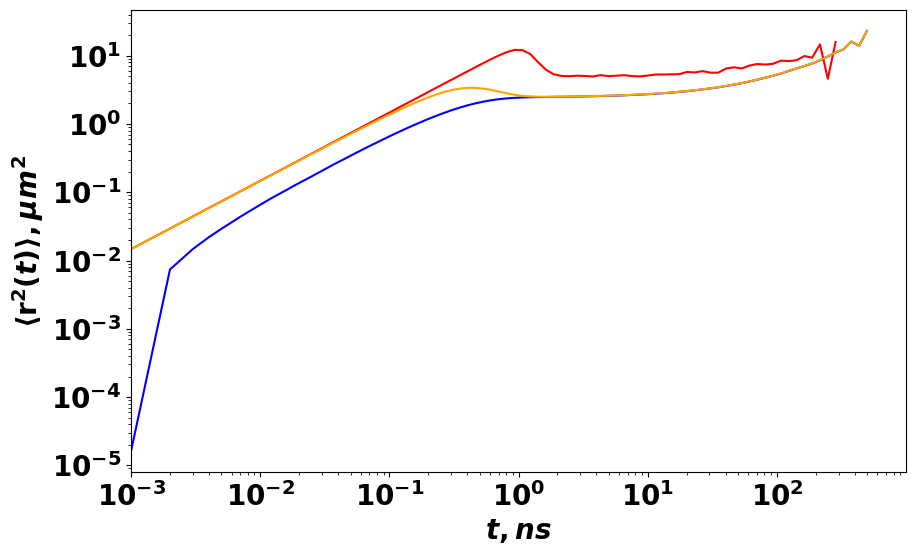

/var/folders/0z/z1b441lj31zbg8g3nwjhg74r0000gn/T/ipykernel_97483/2558262614.py:58: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(time_steps), max(time_steps))


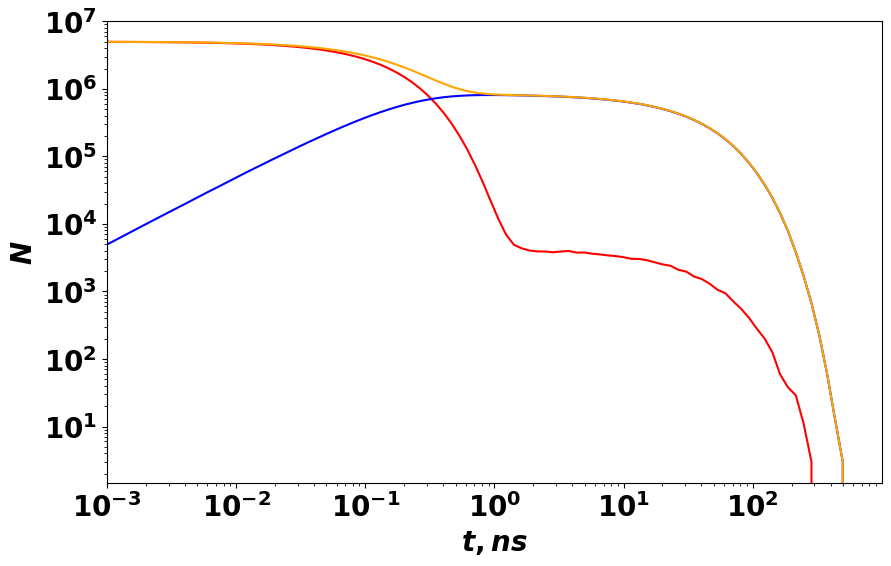

In [ ]:
analyze_trajectories_with_analytical(result)

In [ ]:
from utils import import_analytical_msd_df, import_analytical_num_df

analytical_msd_df_path = r'/Users/a1/Downloads/model_excitons_simulation/data/msd_Fig8_5x10^6'
analytical_popul_df_path = r'/Users/a1/Downloads/model_excitons_simulation/data/popul_Fig8_5x10^6'

analytical_msd_df = import_analytical_msd_df(analytical_msd_df_path)
analytical_popul_df = import_analytical_num_df(analytical_popul_df_path)
analyze_trajectories_with_analytical_bin(result, analytical_msd_df, analytical_popul_df)

In [8]:
from utils import save_load_traj

save_load_traj(result, 'sim_msd_fig8_5x10^6', load_file=False) 
#result = None
#result = save_load_traj(result, 'sim_msd_fig8_5x10^6not0', load_file=True)

: 

/var/folders/0z/z1b441lj31zbg8g3nwjhg74r0000gn/T/ipykernel_1680/2426867625.py:29: RuntimeWarning: invalid value encountered in true_divide
  msd_data[state] /= population_data[state]


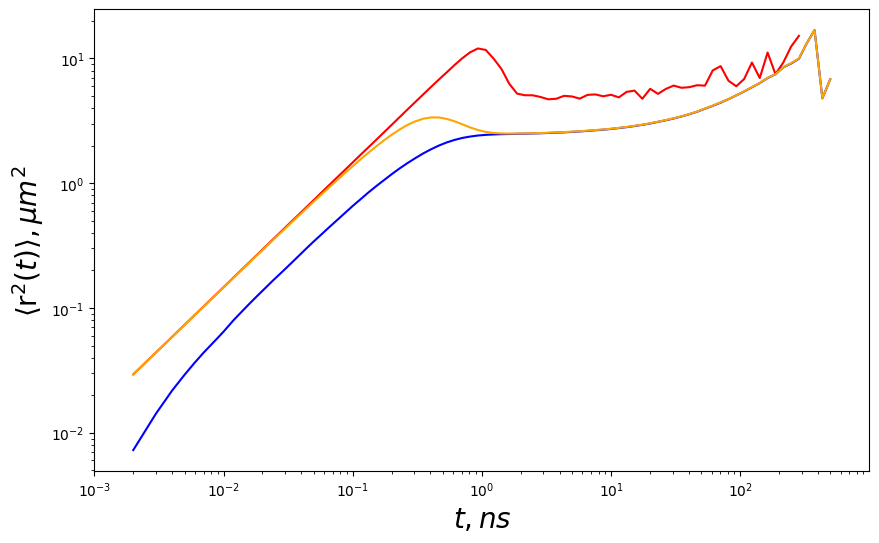

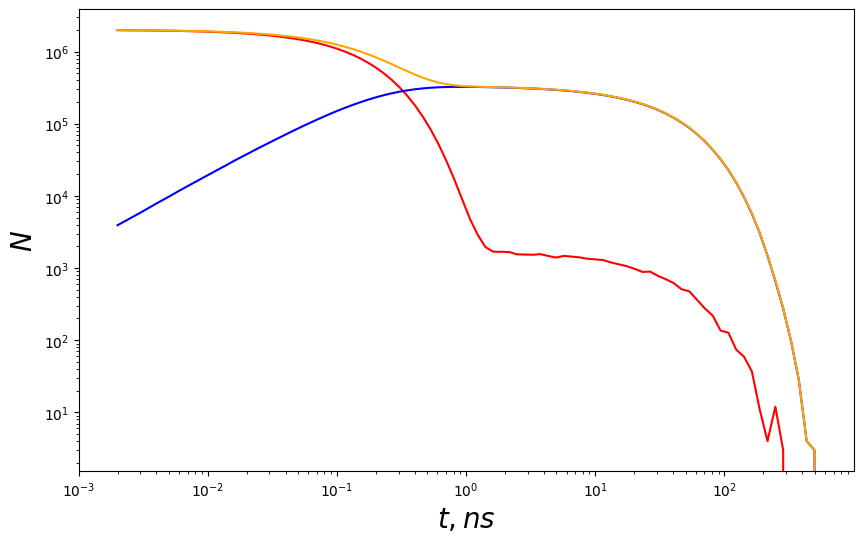

In [ ]:
analyze_trajectories_with_analytical(result)

/var/folders/0z/z1b441lj31zbg8g3nwjhg74r0000gn/T/ipykernel_1680/1004570453.py:49: RuntimeWarning: invalid value encountered in true_divide
  msd_data[state] /= population_data[state]


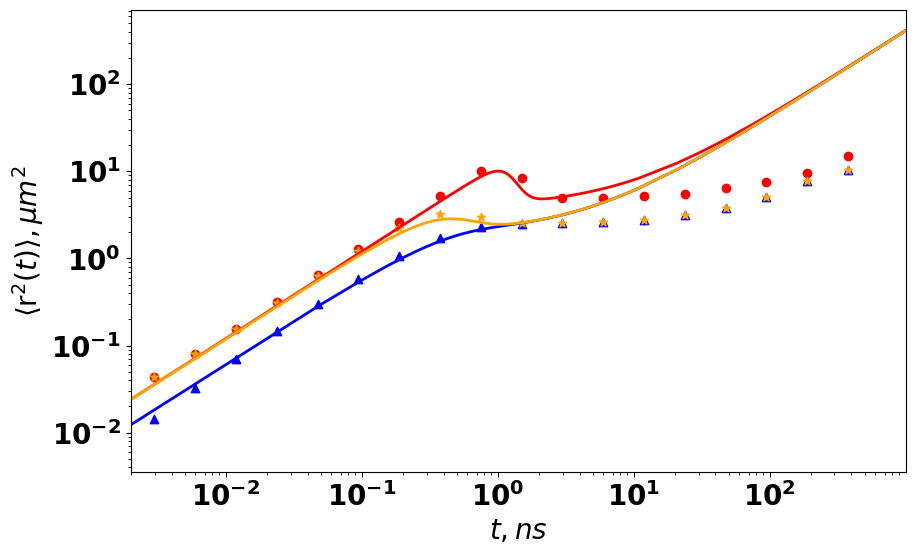

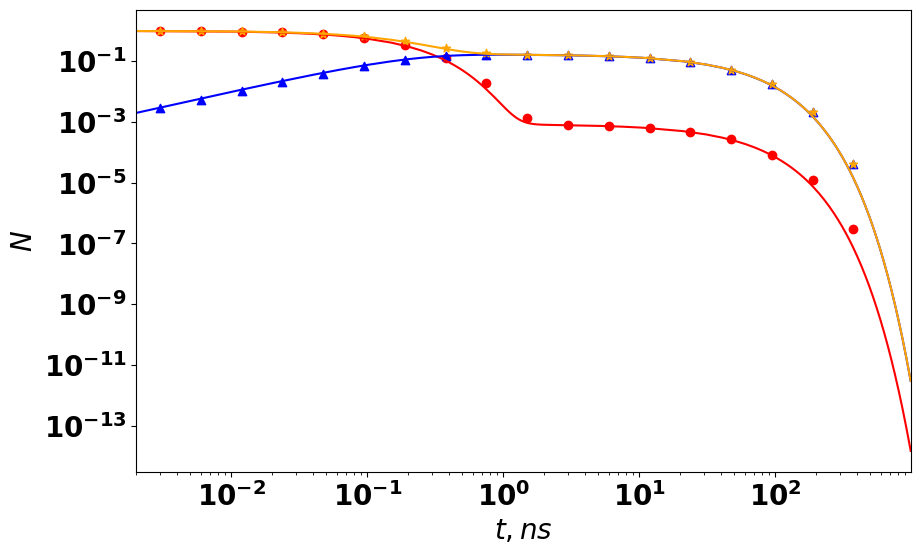

In [ ]:
from utils import import_analytical_msd_df, import_analytical_num_df

analytical_msd_df_path = r'/Users/a1/Downloads/model_excitons_simulation/data/msd_Fig8'
analytical_popul_df_path = r'/Users/a1/Downloads/model_excitons_simulation/data/popul_Fig8'

analytical_msd_df = import_analytical_msd_df(analytical_msd_df_path)
analytical_popul_df = import_analytical_num_df(analytical_popul_df_path)
analyze_trajectories_with_analytical_bin(result, analytical_msd_df, analytical_popul_df)

In [37]:
def plot_analytical_msd(df1, savepath):
    x = df1['t']

    # Extract other columns for y-axis
    y_columns = ['MSD_A', 'MSD_B', 'MSD_overall']
    y_label = ['$MSD_A$', '$MSD_B$', '$MSD_{overall}$']
    colors = ['red', 'blue', 'orange']

    # Plot all other columns against 't'
    plt.figure(figsize=(10, 6))
    for column, label, color in zip(y_columns, y_label, colors):
        plt.plot(x, df1[column], label=label, color=color, linewidth=2)
    # plt.plot(x, df1['shorttime_limit2'], linestyle='--', color='black')
    plt.plot(x, df1['shorttime_limit3'], linestyle='--', color='black')
    plt.plot(x, df1['longtime_limit'], linestyle='--', color='black')

    # Add labels and legend
    plt.xlabel('$t, ns$', fontweight='bold', fontsize=20)
    plt.ylabel('$\\langle r^2(t) \\rangle, \\mu m^2$',
               fontweight='bold', fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.001, 1000)
    # plt.title('Mean Square Displacement over Time')
    # plt.legend()
    plt.savefig(f'{savepath}.png')
    plt.show()

In [39]:
def import_analytical_msd_df(csv_path):
    column_mapping = {
        '0': 't',
        '1': 'MSD_A',
        '2': 'MSD_B',
        '3': 'MSD_overall',
        '4': 'shorttime_limit1',
        '5': 'shorttime_limit2',
        '6': 'shorttime_limit3',
        '7': 'longtime_limit',
        #    '7': 'precision'
    }
    # ,usecols=column_mapping.keys())
    df1_ = pd.read_csv(f'{csv_path}.csv', names=column_mapping.keys())
    # df2_ = pd.read_csv(f'/content/drive/MyDrive/Skoltech_Researches/Exciton_Semiconductors/Fig5L33.csv', names=column_mapping.keys())
    # df3_ = pd.read_csv(f'/content/drive/MyDrive/Skoltech_Researches/Exciton_Semiconductors/Fig5L4.csv', names=column_mapping.keys())
    # Rename columns using the mapping
    df1 = df1_.rename(columns=column_mapping)
    # df2 = df2_.rename(columns=column_mapping)
    # df3 = df3_.rename(columns=column_mapping)

    # df = pd.concat([df1, df2, df3], ignore_index=True)
    df1.head()
    return df1

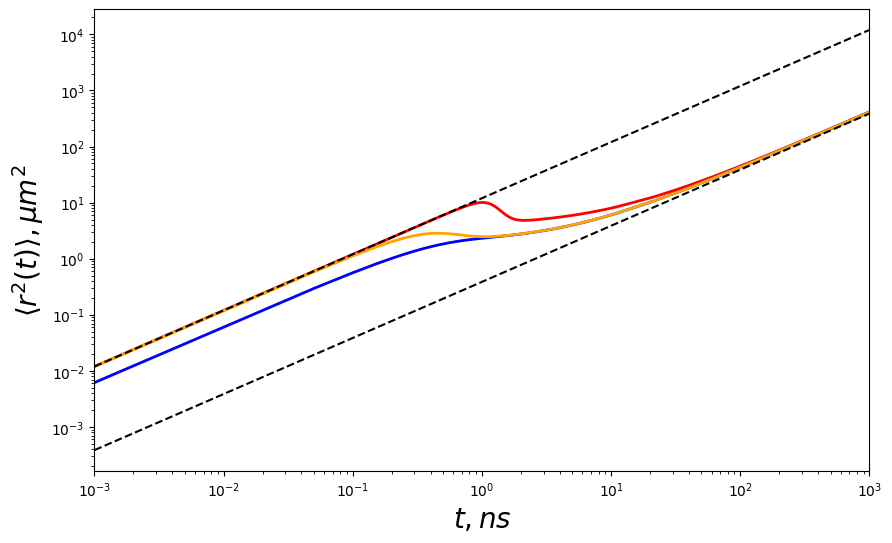

In [40]:

analytical_msd_df_path = r'data/msd_Fig8'
df_msd = import_analytical_msd_df(analytical_msd_df_path)

plot_analytical_msd(df_msd, analytical_msd_df_path)

In [24]:
from utils import save_load_traj

save_load_traj(result, 'sim_msd_fig8_2x10^6', load_file=False)

True

In [ ]:

save_load_traj(result, 'sim_msd_fig8_2x10^6', load_file=False)

In [10]:
from utils import get_analytical_parameter_corresp

n_ensemble = 200*1000
t_cutoff = 1000
dt = 0.001
alpha =1.0
lambda_A = 1.0
lambda_B = 0.03
D_A,D_B =  3.0, 0.1
tau_A, tau_B, sim_lambda_A, sim_lambda_B, sim_alpha = get_analytical_parameter_corresp(D_A=D_A, D_B=D_B, lambda_A=lambda_A, lambda_B=lambda_B, alpha=alpha)

result = run_simulation_multi_parallel(t_cutoff, tau_A, tau_B, dt, lambda_A, lambda_B, alpha, n_ensemble)

100%|██████████| 200000/200000 [1:55:17<00:00, 28.91it/s]  


/var/folders/0z/z1b441lj31zbg8g3nwjhg74r0000gn/T/ipykernel_32856/2426867625.py:29: RuntimeWarning: invalid value encountered in true_divide
  msd_data[state] /= population_data[state]


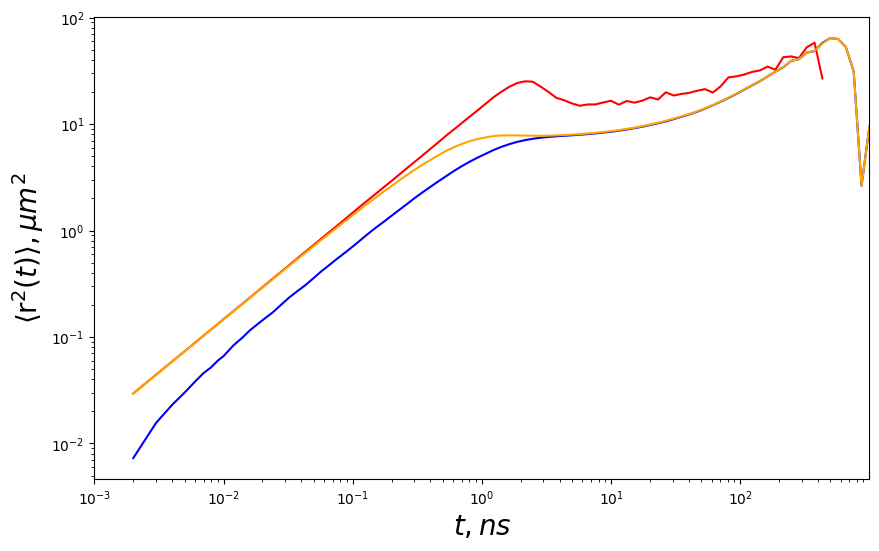

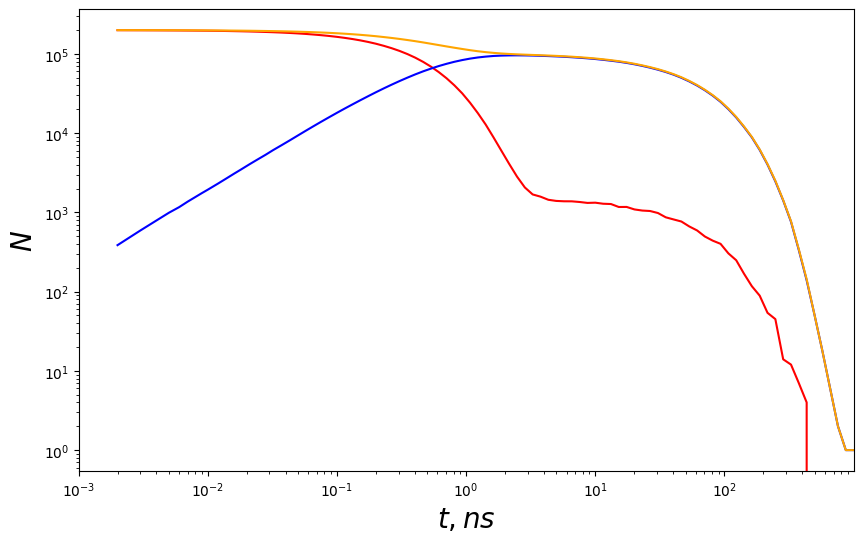

In [12]:
analyze_trajectories(result)

In [40]:
from utils import get_analytical_parameter_corresp

n_ensemble = 20*1000
t_cutoff = 1000
dt = 0.001
alpha =5.0
lambda_A = 1.0
lambda_B = 0.03
D_A,D_B =  3.0, 0.1
tau_A, tau_B, sim_lambda_A, sim_lambda_B, sim_alpha = get_analytical_parameter_corresp(D_A=D_A, D_B=D_B, lambda_A=lambda_A, lambda_B=lambda_B, alpha=alpha)

result = run_simulation_multi_parallel(t_cutoff, tau_A, tau_B, dt, lambda_A, lambda_B, alpha, n_ensemble)

100%|██████████| 20000/20000 [02:12<00:00, 151.47it/s]


/var/folders/0z/z1b441lj31zbg8g3nwjhg74r0000gn/T/ipykernel_43238/2426867625.py:29: RuntimeWarning: invalid value encountered in true_divide
  msd_data[state] /= population_data[state]


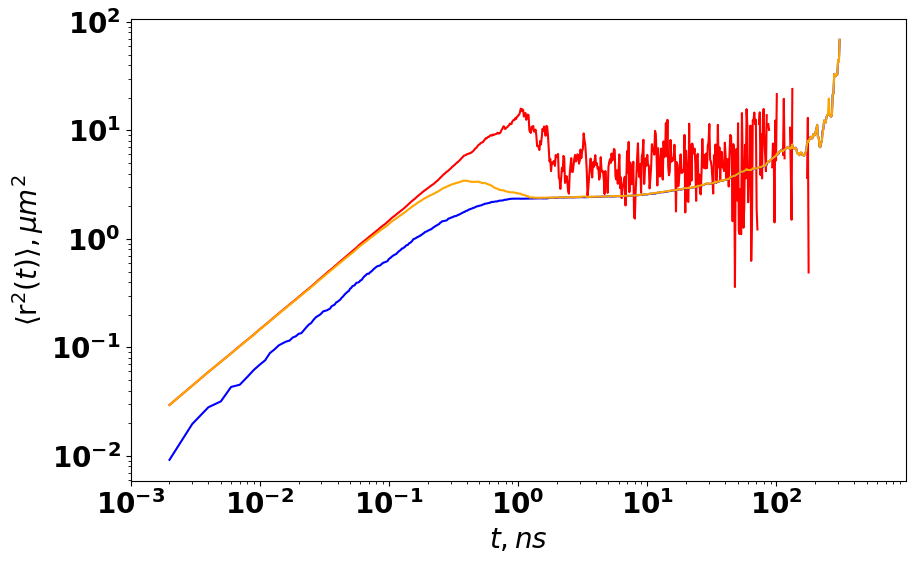

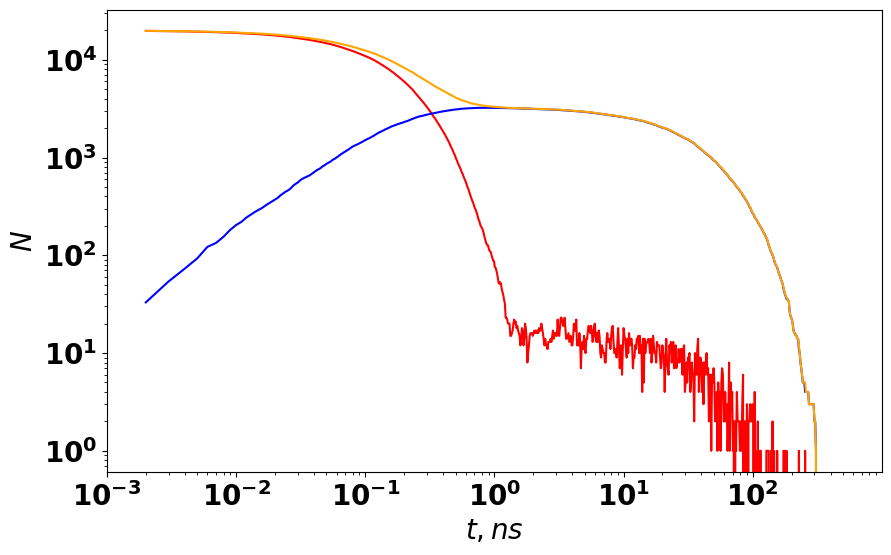

In [41]:
analyze_trajectories(result)

/var/folders/0z/z1b441lj31zbg8g3nwjhg74r0000gn/T/ipykernel_43238/2399198073.py:34: RuntimeWarning: invalid value encountered in true_divide
  msd_data[state] /= population_data[state]


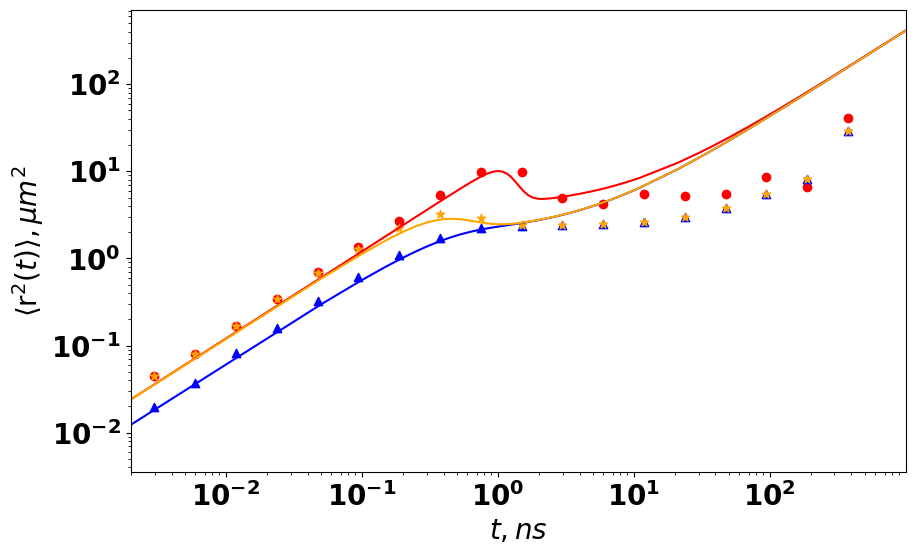

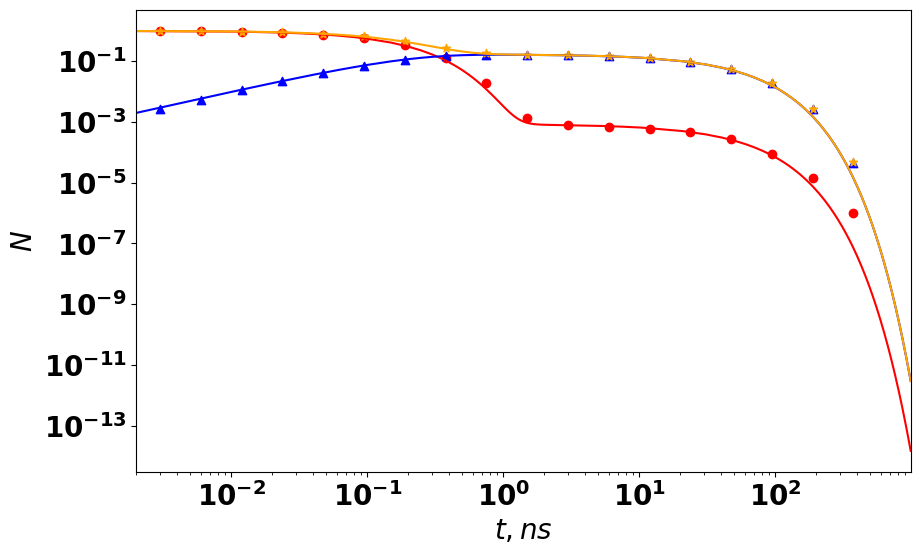

In [42]:
from utils import import_analytical_msd_df, import_analytical_num_df

analytical_msd_df_path = r'data/msd_Fig8'
analytical_popul_df_path = r'data/popul_Fig8'

analytical_msd_df = import_analytical_msd_df(analytical_msd_df_path)
analytical_popul_df = import_analytical_num_df(analytical_popul_df_path)
analyze_trajectories_with_analytical_bin(result, analytical_msd_df, analytical_popul_df)